<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания агрегатор такси собрала исторические данные о заказах такси в аэропортах. 

__Цель:__
Привлечь больше водителей в период пиковой нагрузки

__Задача:__ 
- Построить модель для прогнозирования количества заказов такси на следующий час
- Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

__Действия:__
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.iolib.table import SimpleTable
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score, GridSearchCV
import sklearn.metrics as metrics

Чтение данных

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', 
                 index_col = 'datetime',
                 keep_default_na = False,
                 parse_dates = [0])

Изучим данные

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
# сортировка индекса
df.sort_index(inplace = True)

Итак, у нас имеется временной ряд. Давайте построим график

<AxesSubplot:xlabel='datetime'>

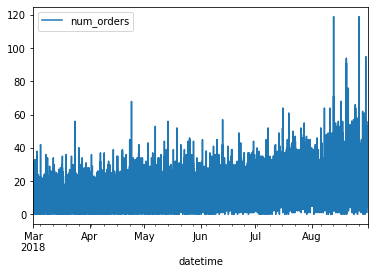

In [6]:
df.plot(y = 'num_orders')

С целью укрупнения дискретности дат проведем ресемплирование временного ряда.

In [7]:
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


__Количество объектов снизилось с 26496 до 4416__ 

In [8]:
df['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

<AxesSubplot:>

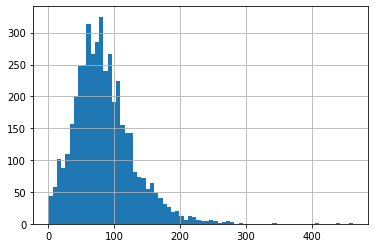

In [9]:
df['num_orders'].hist(bins = 'auto')

Временной ряд представлен за период с марта по август 2018-ого года.

За этот период в среднем заказы за один час составляли 82 штук. Имеются дни, когда заказы доходили более 400 штук.

## Анализ

<AxesSubplot:xlabel='datetime'>

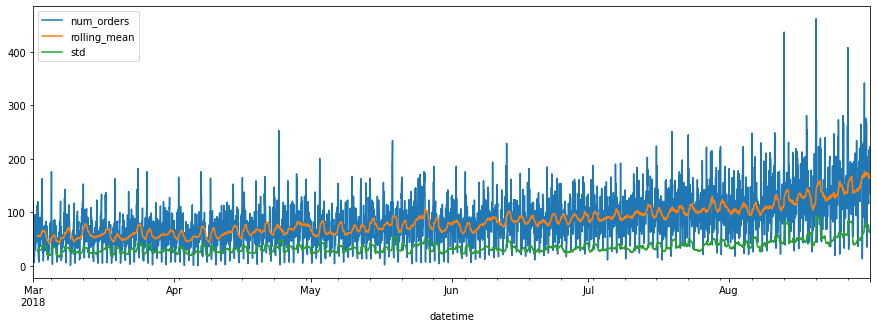

In [11]:
df['rolling_mean'] = df['num_orders'].rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()
df.plot(figsize = (15, 5))

График имеет слабый тренд. Ряд возможно не является стационарным, имеется рост с июля 2018 года.

Многие методы и модели основаны на предположениях о стационарности ряда, но как было замечено ранее наш ряд таковым скорее всего не является. Поэтому для проверки проверки стационарности проведем обобщенный тест Дикки-Фуллера на наличие единичных корней:

In [12]:
result = adfuller(df['num_orders'], autolag='AIC')
print('Критерий ADF: %f' % result[0])
print('P-значение: %f' % result[1])
print('Критические значения:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд стационарен


Разложим временной ряд на тренд и сезонную компоненту:

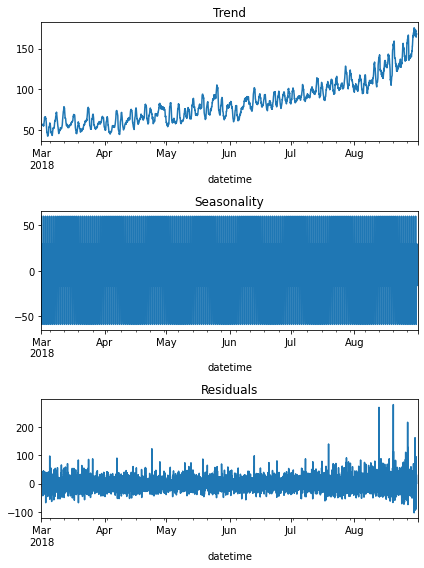

In [13]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()

Имеется тренд по росту числа заказов. Сезонный тренд не наблюдается. Остатки необъяснимы

## Обучение

In [14]:
# Функция для дополнения датасета фичами календарного типа
def make_calendar_features(data):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    return data

In [15]:
# Удалим вспом столбцы
df = df.drop(columns = {'rolling_mean', 'std'}, axis = 1)

# Добавим календарные фичи
make_calendar_features(df)

,num_orders,year,month,day,dayofweek
datetime,,,,,
2018-03-01 00:00:00,124,2018,3,1,3
2018-03-01 01:00:00,85,2018,3,1,3
2018-03-01 02:00:00,71,2018,3,1,3
2018-03-01 03:00:00,66,2018,3,1,3
2018-03-01 04:00:00,43,2018,3,1,3
...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4
2018-08-31 20:00:00,154,2018,8,31,4
2018-08-31 21:00:00,159,2018,8,31,4


Разделим на обучаующую и тестовую выборки

In [16]:
train, test = train_test_split(df, shuffle = False, test_size = 0.1)

X_train = train.drop(columns = 'num_orders', axis = 1)
y_train = train['num_orders']

X_test = test.drop(columns = 'num_orders', axis = 1)
y_test = test['num_orders']

In [17]:
# Функция вывода метрик ошибки

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

Обучим несколько вариантов моделей

LR: -0.013201 (0.017220)
NN: -0.027441 (0.024698)
KNN: -0.409278 (0.172369)
RF: -0.112280 (0.074825)
SVR: -0.267573 (0.195317)


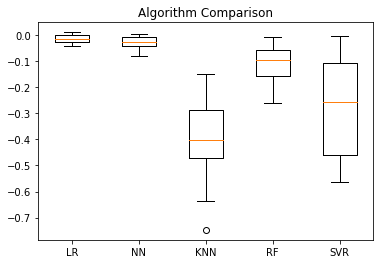

In [18]:
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) 
models.append(('SVR', SVR(gamma='auto')))

# Оценка по очереди
results = []
names = []
for name, model in models:
    # Перекрестная проверка временного ряда
    tscv = TimeSeriesSplit(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Сравнение результатов
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

Лучше всего работают LR, NN, RF. Для дальнейшей работы выберем Линейную регрессию

In [19]:
# Функция для кастомной метрики RMSE
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = metrics.make_scorer(rmse, greater_is_better = False)

In [20]:
def make_lag_rolling_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] =  data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace = True)
    return data

In [21]:
make_lag_rolling_features(df, 100, 10)

train, test = train_test_split(df, shuffle = False, test_size = 0.1)

X_train = train.drop(columns = 'num_orders', axis = 1)
y_train = train['num_orders']

X_test = test.drop(columns = 'num_orders', axis = 1)
y_test = test['num_orders']

index = X_test

In [22]:
# Обучение линейной регрессии
model = LinearRegression()
param_search = {'fit_intercept':[True,False], 'copy_X':[True, False]} #'normalize':[True,False]} 

tscv = TimeSeriesSplit(n_splits=10)

gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)

gsearch.best_score_

-3946.458398483189

## Тестирование

In [23]:
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.5381
mean_squared_log_error:  0.0988
r2:  0.4983
MAE:  30.663
MSE:  1746.199
RMSE:  41.7875


In [59]:
y_pred_df = pd.DataFrame(y_pred, index = X_test.index, columns = {'num_orders'})
y_test_df = pd.DataFrame(y_test, index = X_test.index, columns = {'num_orders'})

y_pred_df['num_orders_rolling'] = y_pred_df['num_orders'].rolling(48).mean()
y_test_df['num_orders_rolling'] = y_test_df['num_orders'].rolling(48).mean()

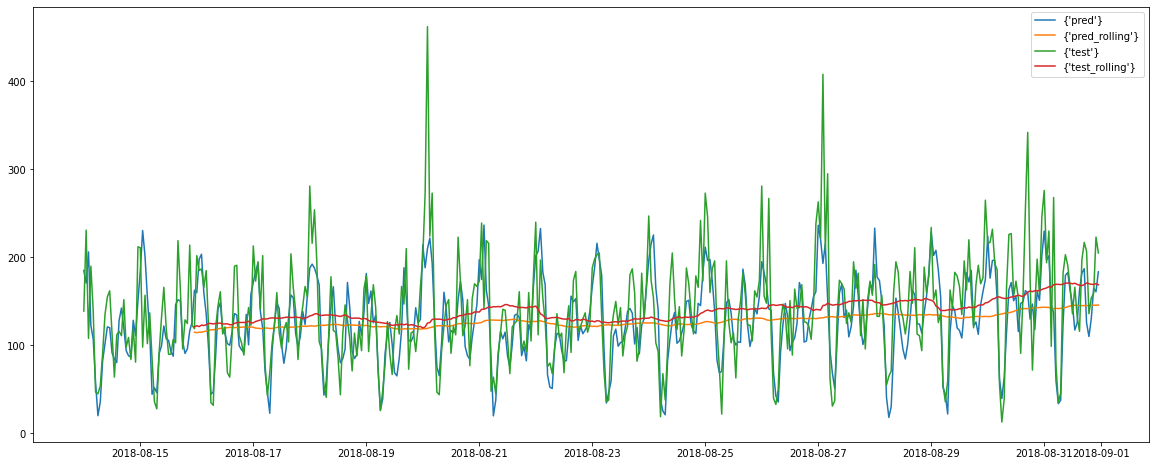

In [73]:
plt.figure(figsize=(20,8))

plt.plot(y_pred_df['num_orders'], label = {'pred'} )
plt.plot(y_pred_df['num_orders_rolling'], label = {'pred_rolling'} )
plt.plot(y_test_df['num_orders'], label = {'test'} )
plt.plot(y_test_df['num_orders_rolling'], label = {'test_rolling'} )

plt.legend()
plt.show()

 ## Вывод

- Временной ряд стационарный, что подтверждается тестом Дикки-Фуллера. Однако последний месяц-два тренд набирает обороты и в скором времени надо будет обучать модель на интегрированных рядах первого порядка (на разностях).
- По результатам обучения нескольких моделей наилучший результат получен на линейной регрессии
- На тестовой выборке по RMSE достигли ~42 заказов.